# Import Statement

In [5]:
import sys
import numpy as np
import pandas as pd
import datetime
sys.path.append("../src")

from etl import *
from eda import *
from scipy.signal import periodogram

import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'iframe' # had to use this one, as the default didn't work

# 1. Load Data

In [6]:
## Data Load params
# Define data types of columns. Note that for some we do not need the higher precision and can safe us some RAM
dtypes_csv = {"transit_mode": "string",
              "station_complex_id": "string",
              "station_complex": "string",
              "borough": "string",
              "payment_method": "string",
              "fare_class_category": "string",
              "ridership": "Int64",
              "transfers": "Int64",
              "latitude": np.float32, 
              "longitude": np.float32,
              "Counties": np.float32,
              "NYS Municipal Boundaries": "Int32",
              "New York Zip Codes": "Int32",
              "Georeference": object}

parse_dates = "transit_timestamp"
dir_data = os.path.join("..", "data", "MTA_Subway_Hourly_Ridership__Beginning_February_2022_20240404_subset_long.csv")


In [7]:
mta_data = DataLoaderRidership(dir_data,
                                 time_col="transit_timestamp",
                                 dtype_dict=dtypes_csv,
                                 date_format="%m/%d/%Y %I:%M:%S %p")
df = mta_data.df

In [8]:
print(df.info(show_counts=True)) # Has additional time and daily ridership columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12158985 entries, 0 to 12158984
Data columns (total 23 columns):
 #   Column                      Non-Null Count     Dtype         
---  ------                      --------------     -----         
 0   transit_timestamp           12158985 non-null  datetime64[ns]
 1   transit_mode                12158985 non-null  string        
 2   station_complex_id          12158985 non-null  string        
 3   station_complex             12158985 non-null  string        
 4   borough                     12158985 non-null  string        
 5   payment_method              12158985 non-null  string        
 6   fare_class_category         12158985 non-null  string        
 7   ridership                   12158985 non-null  Int64         
 8   transfers                   12158985 non-null  Int64         
 9   latitude                    12158985 non-null  float32       
 10  longitude                   12158985 non-null  float32       
 11  Georefere

Let us already add the category column for selecting the stations based on average daily ridership later.

In [9]:
mta_data.add_daily_ridership_quantiles()
df = mta_data.df
print(df.info(show_counts=True)) # Has additional quartile grouping columns

Creating grouping based on the quantiles: (0.0, 0.25, 0.5, 0.75, 1.0)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12158985 entries, 0 to 12158984
Data columns (total 26 columns):
 #   Column                      Non-Null Count     Dtype         
---  ------                      --------------     -----         
 0   transit_timestamp           12158985 non-null  datetime64[ns]
 1   transit_mode                12158985 non-null  string        
 2   station_complex_id          12158985 non-null  string        
 3   station_complex             12158985 non-null  string        
 4   borough                     12158985 non-null  string        
 5   payment_method              12158985 non-null  string        
 6   fare_class_category         12158985 non-null  string        
 7   ridership                   12158985 non-null  Int64         
 8   transfers                   12158985 non-null  Int64         
 9   latitude                    12158985 non-null  float32       
 10  longit

# 2. Exploratory Data Analysis
In the following we create a time period variable as for each of the target months (Mar 2022, Feb 2023 and Jan 2024) we obtained also the previous month.

In [10]:
cond_list = [df["year"] == 2022, 
            ((df["year"] == 2023) & (df["month"].isin([1, 2]))), # Select only Feb and Jan 2023
            ((df["year"] == 2023) & (df["month"] == 12)) | (df["year"] == 2024)] # Dec 2023 requires us to filter for specific year months
choice_list = ["Mar 22", "Feb 23", " Jan 24"] # labels for time periods
df["time_period"] = np.select(condlist=cond_list, choicelist=choice_list, default=np.nan)

## 2.1 General Descriptive Analysis

In [7]:
# According to https://data.ny.gov/api/views/wujg-7c2s/files/06a21181-beca-49e4-adfb-b2fe11605cde?download=true&filename=MTA_SubwayHourlyRidership_Overview.pdf
# Is a single data point identified by a station, a time point (per hour), a fare class, and a fare payment method. To have faster executions, we can thus just 
# select a single week
start_date = np.datetime64("2023-01-23 01:00:00")
end_date = start_date + np.timedelta64(7, "D")
mask = (df["transit_timestamp"] >= start_date) & (df["transit_timestamp"] <= end_date)
df_subset_descr = df.loc[mask]

# Number of stations per boroughs
print("Number of stations per borough\n")
display(df_subset_descr.groupby("borough")["station_complex_id"].nunique())

print("\nTotal number of stations: ", df_subset_descr["station_complex_id"].nunique(), "\n")

# Overview fare class categories
print("Unique fare class categories\n")
display(df_subset_descr["fare_class_category"].unique())

# What is the most popular ticket class per borough within our time periods?
full_fc = df.groupby("borough")["fare_class_category"].value_counts()
mask = full_fc.groupby(level="borough").apply(lambda x: x == x[x.idxmax()])
print("\n Most prevalent ticket class per borough: \n")
display(full_fc.loc[mask.values])

Number of stations per borough



borough
Bronx             68
Brooklyn         156
Manhattan        123
Queens            79
Staten Island      2
Name: station_complex_id, dtype: int64


Total number of stations:  428 

Unique fare class categories



<StringArray>
[               'Metrocard - Other', 'Metrocard - Seniors & Disability',
             'Metrocard - Students',      'Metrocard - Unlimited 7-Day',
                 'OMNY - Full Fare',     'Metrocard - Unlimited 30-Day',
            'Metrocard - Full Fare',            'Metrocard - Fair Fare',
      'OMNY - Seniors & Disability',                     'OMNY - Other']
Length: 10, dtype: string


 Most prevalent ticket class per borough: 



borough        fare_class_category  
Bronx          Metrocard - Full Fare    271946
Brooklyn       Metrocard - Full Fare    614412
Manhattan      Metrocard - Full Fare    498115
Queens         Metrocard - Full Fare    306890
Staten Island  Metrocard - Full Fare      7765
Name: count, dtype: int64

## 2.2 Descriptive analysis of daily ridership variable

In [8]:
# Busiest weekdays for each time period and borough?
bus_ridership = df.groupby(["time_period", "borough"]).aggregate({"daily_ridership": ["min", "max"]})
index_max = df.groupby(["time_period", "borough"])["daily_ridership"].idxmax()
index_min = df.groupby(["time_period", "borough"])["daily_ridership"].idxmin()
bus_ridership["weekday_min"] = df.loc[index_min, "weekday_name"].values
bus_ridership["weekday_max"] = df.loc[index_max, "weekday_name"].values
display(bus_ridership)

daily_ridership         weekday_min weekday_max
                                      min     max                        
time_period borough                                                      
 Jan 24     Bronx                       2   19233      Sunday    Thursday
            Brooklyn                    1   39912    Saturday   Wednesday
            Manhattan                   1  156280    Saturday   Wednesday
            Queens                      1   58386    Saturday      Friday
            Staten Island              99    7873      Monday     Tuesday
Feb 23      Bronx                       1   14105    Saturday   Wednesday
            Brooklyn                    1   36809      Sunday   Wednesday
            Manhattan                   1  130825    Saturday   Wednesday
            Queens                      1   43933      Sunday     Tuesday
            Staten Island              69    7485      Sunday     Tuesday
Mar 22      Bronx                      59   13692    Saturday   Wednesday
            Brooklyn                    1   33428      Sunday   Wednesday
            Manhattan                   1  108824    Saturday   Wednesday
            Queens                      1   38215      Sunday   Wednesday
            Staten Island             135    7215      Sunday     Tuesday

Staten Island deviation can be explained by the fact that the tram does not operate 24/7 but rather on fixed schedules depending on the weekday and holidays. Ohterwise, it is clear that the busiest days are usually business days, whereas weekends tend to be less busy. Before we verify this by generating ridership plots, let us first check if timestamps are just omitted if no one entered or left the station within a hour. 

In [9]:
# What if there are not riders at a certain time point? Are those omitted? 
count_df = df.groupby(["station_complex_id", "fare_class_category", "date"])["ridership"].count().reset_index()
test_sample = count_df[count_df["ridership"]!=24].sample(3, random_state=42).drop("ridership", axis=1)
# display(pd.merge(df, test_sample, on=["station_complex_id", "fare_class_category", "date"], how="inner")\
#         .sort_values(["station_complex_id", "fare_class_category", "date", "transit_timestamp"]))
# Seems like this is the case, as there are no times with 0 ridership, and some hours are missing, where one would not assume that the train didn't operate. Display omitted for visual aesthetics

In [174]:
# Exact calculation
# We now calculate for each hour, how often an hour does not exist in the data set. We explicitly only look at subway stations, as the other two might have very different opening hours
df_test = df.copy()


# Only subway
mask = df_test["transit_mode"] == "subway"
df_test = df_test[mask]

# Aggregate to hours to remove influence of fare class
df_test = df_test.groupby(["station_complex_id", "date", "transit_timestamp"])["ridership"].agg("sum").reset_index()

# Step 1: Extract hour and date
df_test["date"] = df_test["transit_timestamp"].dt.date
df_test["hour"] = df_test["transit_timestamp"].dt.hour

# Step 2: Group by 'station_complex_id', 'date', and 'hour'
grouped = df_test.groupby(["station_complex_id", "date", "hour"]).size()

# Step 3: Create a full index of all expected hours for each station and date
dates = df_test["date"].unique()
hours = np.arange(24)  # 0 to 23 hours
stations = df_test["station_complex_id"].unique()

full_index = pd.MultiIndex.from_product([stations, dates, hours], names=["station_complex_id", "date", "hour"])

# Step 4: Reindex the grouped data to include all possible hours for each station and date
complete_data = grouped.reindex(full_index, fill_value=0)

# Step 5: Identify missing hours (where size is 0)
missing_hours = complete_data[complete_data == 0]

# Step 6: Count the number of times each specific hour is missing for each station
missing_counts = missing_hours.reset_index().groupby("hour").size()
display(missing_counts)

hour
0     4126
1     5855
2     7020
3     5241
4     3055
5     2362
6     2277
7     2260
8     2270
9     2263
10    2277
11    2288
12    2260
13    2226
14    2220
15    2208
16    2201
17    2207
18    2257
19    2329
20    2372
21    2412
22    2629
23    2990
dtype: int64

We can certainly see that there seem to be hours where some stations are closed (1, 2, and 3 in the morning) but we can also see that there are missing hours across all possible hours, so we can safely assume that hours with no ridership lead to a missing row. To be fully save, let us retrieve some stations, with no ridership during the day, so we can be sure that those have nothing to do with opening hours.

In [190]:
per_station_df = missing_hours.reset_index().groupby(["station_complex_id", "hour"]).size().reset_index()
per_station_df.columns = ['station_complex_id', 'hour', "no_miss_hours"]
mask = (per_station_df["hour"].isin(np.arange(11, 16, 1))) & (per_station_df["no_miss_hours"]>0)
subset = per_station_df[mask].groupby("station_complex_id")["no_miss_hours"].sum().reset_index()

# Add name and borough
subset = pd.merge(subset, df.drop_duplicates(["station_complex_id", "borough"]), on="station_complex_id", how="left")
subset[["station_complex", "borough"]]

,station_complex,borough
0,"Astoria-Ditmars Blvd (N,W)",Queens
1,"49 St (N,R,W)",Manhattan
2,"Hewes St (M,J)",Brooklyn
3,"Marcy Av (M,J,Z)",Brooklyn
4,"Bowery (J,Z)",Manhattan
...,...,...
420,"Gates Av (J,Z)",Brooklyn
421,Kosciuszko St (J),Brooklyn
422,"Myrtle Av (M,J,Z)",Brooklyn
423,"Flushing Av (M,J)",Brooklyn


Now that this is sorted out, let us generate daily ridership plots to get a feel for the seasonality of the data.

In [10]:
# Prepare df and aggregate to borough and fare class per weekday
agg_df = df.groupby(["time_period", "borough", "fare_class_category", "weekday_name", "weekday"])["ridership"].sum().reset_index()

# Add total ridership
totals = agg_df.groupby(["time_period", "weekday_name", "fare_class_category", "weekday"])["ridership"].sum().reset_index()
totals["borough"] = "total"

# Concat
agg_df = pd.concat([agg_df, totals],ignore_index=True, axis=0)

# Order Weekday based on occurence in week
agg_df = agg_df.sort_values(["time_period", "borough", "fare_class_category", "weekday"])

# Create plot for each time period seperately
for tp in agg_df["time_period"].unique():
    mask = agg_df["time_period"] == tp
    subset_df = agg_df.loc[mask]
    fig = ts_lineplot_facet(subset_df, x_var="weekday_name", y_var="ridership", height=1100, width = 1200,
                      color="borough", title=f"Total ridership per Weekday, grouped by Borough for period {tp}",
                      facet_col="fare_class_category",facet_col_wrap=4)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # Remove var= in subtitle
    for axis in fig.layout:
        if axis.startswith('xaxis'):
            fig.layout[axis].showticklabels = True  # Ensuring tick labels are shown for all x-axes
            fig.layout[axis].title = None # Remove Variable title
    fig.show()

We can deduce the following:
1. The expected pattern is clearly visable, where weekends are usually less busier than business days
2. There are clearly changes in the distributions of ridership in fare classes across the timeperiods, although the ones with the highest ridership (OMNY / Metrocard - Full Fare) stay the same
3. In period Mar 2022 there seem to be an unusal pattern where the maximum ridership is reached on Wednesday, in contrast in period Jan 2024 the peak is on Tuesday instead. In Feb 2023 the weekdays are fairly similar in their numbers, except Monday and Friday, which is the same for all periods.
4. Unsurprisingly, Manhatten is the borough with the most riderships out of all of the six boroughs in the data set.
5. It is kind of funny that students do not seem to use the public transport except for weekdays, which probably points to the fact that the students that do not live near their campus in dorms, have to travel a lot to get to campus.

Let us explicitly look at the different transit modes (i.e. subway, Staten Island Railway, and the Roosevelt Island Tram as I would expect a difference in ridership volumes)

In [11]:
# Prepare df and aggregate to borough and transit mode per weekday
agg_df = df.groupby(["time_period", "borough", "transit_mode", "weekday_name", "weekday"])["ridership"].sum().reset_index()

# Add total ridership
totals = agg_df.groupby(["time_period", "weekday_name", "transit_mode", "weekday"])["ridership"].sum().reset_index()
totals["borough"] = "total"

# Concat
agg_df = pd.concat([agg_df, totals],ignore_index=True, axis=0)

# Order Weekday based on occurence in week
agg_df = agg_df.sort_values(["time_period", "borough", "transit_mode", "weekday"])

# Create plot for each time period seperately
for tp in agg_df["time_period"].unique():
    mask = agg_df["time_period"] == tp
    subset_df = agg_df.loc[mask]
    fig = ts_lineplot_facet(subset_df, x_var="weekday_name", y_var="ridership", height=500, width = 1100,
                      color="borough", title=f"Total Ridership per Weekday, grouped by Transit Mode for Period {tp}",
                      facet_col="transit_mode",facet_col_wrap=4)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # Remove var= in subtitle
    
    for axis in fig.layout:
        if axis.startswith('xaxis'):
            fig.layout[axis].showticklabels = True  # Ensuring tick labels are shown for all x-axes
            fig.layout[axis].title = None # Remove Variable title
    fig.update_yaxes(matches=None)
    fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
    fig.show()

In a sense our assumption was partly correct, as we can clearly see peaks or a local maximums around Saturday and Sunday for the Roosevalt Island tram. After research we can also understand why Staten Island does still exhibit the same pattern as the rest of the boroughs. Staten Island is actually an area that includes residential as well as commercial buildings, hence the the Staten Island Railway is probably used for commuting to work or to get home, and not mainly to visit tourist attractions.

Let us now also look at the full time periods, maybe we can detect some outliers in the seasonal pattern.

In [12]:
# Prepare df and aggregate to borough per day
agg_df = df.groupby(["time_period", "borough", "date"])["ridership"].sum().reset_index()

# Add total daily ridership
totals = agg_df.groupby(["time_period", "date"])["ridership"].sum().reset_index()
totals["borough"] = "total"

# Concat
agg_df = pd.concat([agg_df, totals],ignore_index=True, axis=0)

# Order Weekday based on period, borough, and date
agg_df = agg_df.sort_values(["time_period", "borough", "date"])

# Create plot for each time period seperately
fig = ts_lineplot_facet(agg_df, x_var="date", y_var="ridership", height=400, width = 1500,
                  color="borough", title=f"Daily Ridership per Day, grouped by Borough",
                  facet_col="time_period",facet_col_wrap=3)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # Remove var= in subtitle

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].showticklabels = True  # Ensuring tick labels are shown for all x-axes
        fig.layout[axis].title = None # Remove Variable title
        fig.layout[axis].matches = None # Individual x axis
fig.show()

We make the following observations:
1. The daily ridership range seems to be different in Mar 22 when compared to the other two periods.
2. We can clearly detect two outlier weeks, one is Christmas in 2023 and the other one is the week starting from 31st of January in 2022. Looking at https://en.wikipedia.org/wiki/February_2022_North_American_winter_storm yields that New York City was impacted by a significant winter storm, which explains the outlier.
3. Lastly, the ridership figures for the beginning of December seem to be higher than the rest of the time periods, which might be explained by a higher tourist account or in general that people travel a lot more to get to attractions / buy presents.

As the main task requires us to predict ridership values for stations coming from each of the average ridership quartiles, it makes sense to repeat the weekday daily ridership and the previous plot for each of the quartiles stations seperately. 

In [13]:
# Prepare df and aggregate to quartile group per weekday
agg_df = df.groupby(["time_period", "quant_group", "weekday_name", "weekday"], observed=True)["ridership"].sum().reset_index() # Observed is needed as quant_group is a categorical

# # Add total ridership
# totals = agg_df.groupby(["time_period", "weekday_name", "weekday"])["ridership"].sum().reset_index()
# totals["borough"] = "total"

# # Concat
# agg_df = pd.concat([agg_df, totals],ignore_index=True, axis=0)

# Order Weekday based on occurence in week
agg_df = agg_df.sort_values(["time_period", "quant_group", "weekday"])

# Create plot for each time period 
fig = ts_lineplot_facet(agg_df, x_var="weekday_name", y_var="ridership", height=600, width = 900,
                  color="quant_group", title=f"Total ridership per Weekday, grouped by Quartile Group",
                  facet_col="time_period",facet_col_wrap=4)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # Remove var= in subtitle
for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].showticklabels = True  # Ensuring tick labels are shown for all x-axes
        fig.layout[axis].title = None # Remove Variable title
fig.show()

In [14]:
# Prepare df and aggregate to borough per day
agg_df = df.groupby(["time_period", "quant_group", "date"], observed=True)["ridership"].sum().reset_index()

# # Add total daily ridership
# totals = agg_df.groupby(["time_period", "date"])["daily_ridership"].sum().reset_index()
# totals["borough"] = "total"

# # Concat
# agg_df = pd.concat([agg_df, totals],ignore_index=True, axis=0)

# Order Weekday based on period, borough, and date
agg_df = agg_df.sort_values(["time_period", "quant_group", "date"])

# Create plot for each time period seperately
fig = ts_lineplot_facet(agg_df, x_var="date", y_var="ridership", height=400, width = 1500,
                  color="quant_group", title=f"Daily Ridership per Day, grouped by Borough",
                  facet_col="time_period",facet_col_wrap=3)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])) # Remove var= in subtitle

for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].showticklabels = True  # Ensuring tick labels are shown for all x-axes
        fig.layout[axis].title = None # Remove Variable title
        fig.layout[axis].matches = None # Individual x axis
fig.show()

The plots do not yield much more information than the previous ones. Alternatively, we did replicate the plots additionally grouped by borough but this did not yield any surprising results beyond what we already knew. Let us also get the distribution of boroughs or rather stations from certain boroughs per group to see if there is anything that surprises us.

In [15]:
print("Number of stations per quartile group, ordered:\n")
display(df.groupby(["quant_group", "borough"], observed=True)["station_complex_id"].nunique().reset_index().sort_values(by=["quant_group", "station_complex_id"], ascending=False))

print("For comparision order given by total ridership:\n")
display(df.groupby("borough")["ridership"].sum().sort_values(ascending=False))

print("For comparision order given by total number of stations:\n")
display(df.groupby("borough")["station_complex_id"].nunique().sort_values(ascending=False))

Number of stations per quartile group, ordered:



,quant_group,borough,station_complex_id
16,"(75, 100]",Manhattan,68
17,"(75, 100]",Queens,21
15,"(75, 100]",Brooklyn,14
14,"(75, 100]",Bronx,3
10,"(50, 75]",Brooklyn,46
11,"(50, 75]",Manhattan,32
12,"(50, 75]",Queens,15
9,"(50, 75]",Bronx,13
13,"(50, 75]",Staten Island,1
6,"(25, 50]",Brooklyn,49


For comparision order given by total ridership:



borough
Manhattan        276755727
Brooklyn         116994767
Queens            76828061
Bronx             38539375
Staten Island       935991
Name: ridership, dtype: Int64

For comparision order given by total number of stations:



borough
Brooklyn         156
Manhattan        123
Queens            79
Bronx             68
Staten Island      2
Name: station_complex_id, dtype: int64

The results are a bit surprising in two regards:
1. Brooklyn has not only the most stations, but its stations are also very diverse in terms of average ridership values, as it leads every group, except the upper most quartile, where Manhatten leads.
2. Staten Island seems to have one of the busiest stations, although it has overall the lowest amount of total ridership

## 2.3 Stations which exhibit unusal patterns

Before we move on, let us quickly try to foreshadow whether some stations are much harder to predict. We suspect that stations whose ridership numbers fluctuate a lot during business days or stations where the general seasonality is reversed (i.e. having a higher ridership on weekends than on business days) are more difficult to predict. The first because of the high variance and the seemingly unimportance of the seasonal effect that is going to work and the second due to being most likely stations near tourist attractions or leisure venues which in turn means that the causal factors driving ridership are potentially different from those stations where the seasonal effect is the main mechanism. 
For the first we look at the interquartile range of relative ridership per day to the total ridership for that station per week. This is done, to account for the different order of magnitude in ridership numbers between stations. For the second we will look at the quantiles of the distribution of the relative ridership on business days compared to weekends.

In [16]:
# Remove weekends, remove duplicates and use daily ridership. Calculate daily ridership relative to total business week ridership. 
# Get 25 and 75 quartiles for each station over all time periods for the relative number and calculate IQR
mask = df["weekday"] <= 4

# Add weekly total ridership per station, calculate relative daily 
var_df = df[mask].drop_duplicates(subset=["station_complex", "date"]) # reduce to daily station data without weekends
var_df["week_year"] = pd.to_datetime(var_df["date"]).dt.strftime("%Y-%U") # get year week
var_df["weekly_ridership"] = var_df.groupby(["station_complex", "week_year"])["daily_ridership"].transform("sum")
var_df["rel_daily_ridership"] = var_df["daily_ridership"].values / var_df["weekly_ridership"].values
var_df = var_df.groupby("station_complex")\
               .agg(lower=("rel_daily_ridership", lambda x: np.quantile(x, q=0.25)),
                    upper=("rel_daily_ridership", lambda x: np.quantile(x, q=0.75)))
var_df["iqr"] = var_df["upper"].values - var_df["lower"].values

# Get the top 10 stations according to iqr and add borough
info_df = df.loc[:, ["station_complex", "borough"]].drop_duplicates()
var_subset = var_df.sort_values(by="iqr", ascending=False).head(10)
var_subset = pd.merge(var_subset, info_df, on="station_complex", how="left")

print("Top 10 stations and boroughs with the highest IQR on the daily ridership, relative to total weekly ridership:\n")
display(var_subset)

Top 10 stations and boroughs with the highest IQR on the daily ridership, relative to total weekly ridership:



,station_complex,lower,upper,iqr,borough
0,Houston St (1),0.173326,0.226351,0.053025,Manhattan
1,Canal St (1),0.176326,0.228454,0.052129,Manhattan
2,Aqueduct Racetrack (A),0.177299,0.228712,0.051413,Queens
3,"Wall St (2,3)",0.177135,0.226547,0.049412,Manhattan
4,23 St (6),0.182245,0.230467,0.048223,Manhattan
5,"5 Av/53 St (E,M)",0.179998,0.227282,0.047284,Manhattan
6,"Eastern Pkwy-Brooklyn Museum (2,3)",0.186114,0.231407,0.045293,Brooklyn
7,"47-50 Sts-Rockefeller Ctr (B,D,F,M)",0.178574,0.223524,0.04495,Manhattan
8,"Wall St (4,5)",0.180988,0.224487,0.043498,Manhattan
9,50 St (1),0.177797,0.221124,0.043328,Manhattan


We will test those ten stations later and compare their performance with the ones we mainly used. But let us now also look at the second part.

In [17]:
# Reduce to only daily station data, Create year week identifier
weekends_df = df.drop_duplicates(subset=["station_complex", "date"]).copy() # reduce to daily station data 
weekends_df["week_year"] = pd.to_datetime(weekends_df["date"]).dt.strftime("%Y-%U") # get year week

# Create weekend and business day indicator
weekends_df["weekend"] = np.where(weekends_df["weekday"].values <=4, 0, 1)

# Get total ridership per business week and weekend, calculate total business ridership relative to weekend for all weeks and stations
agg_weekends_df = weekends_df.groupby(["station_complex", "week_year", "weekend"])["daily_ridership"].sum().reset_index()

# Pivot into a wide format, get total ridership per week, calculate relative difference between week and weekend ridership per week and station 
wide_frame = agg_weekends_df.pivot(index=["station_complex", "week_year"], columns="weekend",  values="daily_ridership").reset_index()
wide_frame.columns = ['station_complex', 'week_year', 'weekday_ridership', 'weekend_ridership']
wide_frame["total_ridership"] = wide_frame["weekday_ridership"] + wide_frame["weekend_ridership"]
wide_frame["rel_diff_week"] = (wide_frame["weekday_ridership"] - wide_frame["weekend_ridership"]) / wide_frame["total_ridership"]

# First stations with lowest ratio on average (meaning weekends are usually more busier than business days)
info_df = df.loc[:, ["station_complex", "borough"]].drop_duplicates()
result_df = wide_frame.groupby("station_complex")["rel_diff_week"].mean().reset_index().sort_values("rel_diff_week").head(10)
result_df = pd.merge(result_df, info_df, on="station_complex")

print("Stations with the on average lowest relative differences of ridership between weekdays and weekends: \n")
display(result_df)

# Secondly stations where this relative difference varies a lot (using IQR again)
# Reduce to only data points where relative difference exist (can have NA if week is not fully in observed month)
mask = wide_frame["rel_diff_week"].notna()
result_df = wide_frame[mask].copy()
result_df = result_df.groupby("station_complex")\
               .agg(lower=("rel_diff_week", lambda x: np.quantile(x, q=0.25)),
                    upper=("rel_diff_week", lambda x: np.quantile(x, q=0.75)))
result_df["iqr"] = result_df["upper"].values - result_df["lower"].values
result_df = pd.merge(result_df, info_df, on="station_complex")
result_subset = result_df.sort_values(by="iqr", ascending=False).head(10)

print("Stations with the highest IQR of the relative difference of ridership between weekdays and weekends: \n")
display(result_subset)

Stations with the on average lowest relative differences of ridership between weekdays and weekends: 



,station_complex,rel_diff_week,borough
0,RI Tramway (Manhattan),0.358615,Manhattan
1,RI Tramway (Roosevelt),0.363492,Manhattan
2,"Prince St (R,W)",0.364779,Manhattan
3,"Bowery (J,Z)",0.401467,Manhattan
4,Spring St (6),0.423083,Manhattan
5,Christopher St-Sheridan Sq (1),0.425379,Manhattan
6,Aqueduct Racetrack (A),0.430387,Queens
7,Lorimer St (L)/Metropolitan Av (G),0.439744,Brooklyn
8,2 Av (F),0.456017,Manhattan
9,"Eastern Pkwy-Brooklyn Museum (2,3)",0.464285,Brooklyn


Stations with the highest IQR of the relative difference of ridership between weekdays and weekends: 



,station_complex,lower,upper,iqr,borough
86,34 St-Hudson Yards (7),0.563833,0.9911,0.427267,Manhattan
108,57 St (F),0.572249,0.998176,0.425927,Manhattan
411,Vernon Blvd-Jackson Av (7),0.611365,0.992365,0.381,Queens
15,"121 St (J,Z)",0.694075,0.981049,0.286973,Queens
128,"75 St-Elderts Ln (J,Z)",0.70682,0.988948,0.282129,Queens
138,85 St-Forest Pkwy (J),0.717812,0.995565,0.277753,Queens
423,"Woodhaven Blvd (J,Z)",0.712641,0.984704,0.272064,Queens
6,"104 St (J,Z)",0.724687,0.993215,0.268528,Queens
167,Avenue U (F),0.73203,0.996605,0.264574,Brooklyn
10,111 St (J),0.730789,0.991253,0.260464,Queens


It is not surprising, that the Roosevelt Island tram station are the ones with the lowest average relative differences, as those are tourist attractions after all. The other stations might feature extensive nightlife or have historic significance (such as Bowery for example). We will test those stations as well and compare their prediction errors with the main group. 

# 3. Forecasting
This section is organized as follows. First, we will sample two stations each from the quartiles, transform the time series data for forecasting, and have a small visual analysis using ACF and PACF plots to determine stationarity and seasonality patterns explicitly. In the next section we are then going to train and evaluate two models, an ARIMA model and a LightGBM based boosted decision tree regressor. We will also explain our rationale behind choosing those models, as well as the training process. Finally, we will also provide forecasts for the stations we suspected difficult to predict and evaluate the effect of adding an additional feature to the ensemble model. 

# 3.1 Data Preperation and Station Selection
As before, the main code is contained in the DataLoader class, available from the etl.py module. Here we already provide transformations that allow one to do the following:
1. Given a list of station ids, a start and end date, subset the data frame attribute accordingly. Here we also allow one to specifiy additional variables that should be retained and how they should be aggregated in the process.
2. For each station id and day:hour aggregate (sum) the ridership variable (thus ignoring fare class differences) and potentially additional variables.
3. As hours with no ridership are non-existing, the function will (depending upon user request) add the missing hours with a ridership of zero and potentially impute NAs in additional variables*
4. Finally, based on user input a column is added that indicates train and test set observations (in our case the first two weeks of the respective time periods)

As training horizon we opted for one month because on one hand this includes the previous month weeks of the test set and because we are sceptical whether a longer training window would benefit any model, as the the forecast is on hourly basis. Besides, we favor in this presentation execution time over model performance. 

Note: The data we downloaded starts always at 13 o'clock on the first day of the previous month. We tried to query the data again to get the other hours as well, but only got partial data due to a 500 error. This will not lead to wrongly added zero ridership values, as the code only consideres missing hours between the start and end time index.

*The first non-null value of that variable of the given day would then be used.

In [24]:
# Sample two stations each from all quartiles
main_stations_df = df.drop_duplicates(subset=["station_complex", "station_complex_id", "borough"])\
    .groupby("quant_group", observed=True).sample(n=2, random_state=42) # random state for reproducibility
sub_set = main_stations_df.loc[:,["station_complex", "station_complex_id", "borough", "quant_group"]]
display(sub_set)

# Prepare the start and end dates for each time period (start, first day of previous month, end is end of two weeks in actual month)
start_date_mar_22 = datetime.date(2022, 2, 1) 
end_date_mar_22 = datetime.date(2022, 3, 1) + datetime.timedelta(days=14)

start_date_feb_23 = datetime.date(2023, 1, 1) 
end_date_feb_23 = datetime.date(2023, 2, 1) + datetime.timedelta(days=14)

start_date_jan_24 = datetime.date(2023, 12, 1) 
end_date_jan_24 = datetime.date(2024, 1, 1) + datetime.timedelta(days=14)

# Prepare the time series for each period without additional variables. Test len is measured in days and takes the last 14 days as test set
ts_mar_22_main = mta_data.model_data_prep(station_ids = main_stations_df["station_complex_id"],
                                         start_date=start_date_mar_22, end_date=end_date_mar_22,
                                         test_len=14)
ts_feb_23_main = mta_data.model_data_prep(station_ids = main_stations_df["station_complex_id"],
                                         start_date=start_date_feb_23, end_date=end_date_feb_23,
                                         test_len=14)
ts_jan_24_main = mta_data.model_data_prep(station_ids = main_stations_df["station_complex_id"],
                                         start_date=start_date_jan_24, end_date=end_date_jan_24,
                                         test_len=14)

# For the visual analysis the group might be interesting as well, so we merge it back to the data
ts_mar_22_main_plot = pd.merge(ts_mar_22_main, sub_set, on="station_complex_id", how="left")
ts_feb_23_main_plot = pd.merge(ts_feb_23_main, sub_set, on="station_complex_id", how="left")
ts_jan_24_main_plot = pd.merge(ts_jan_24_main, sub_set, on="station_complex_id", how="left")

# Convert category back to string 
ts_mar_22_main_plot["quant_group"] = ts_mar_22_main_plot["quant_group"].astype(str)
ts_feb_23_main_plot["quant_group"] = ts_feb_23_main_plot["quant_group"].astype(str)
ts_jan_24_main_plot["quant_group"] = ts_jan_24_main_plot["quant_group"].astype(str)

,station_complex,station_complex_id,borough,quant_group
205558,Atlantic Av (L),133,Brooklyn,"(0, 25]"
103499,"Van Siclen Av (J,Z)",90,Brooklyn,"(0, 25]"
205061,Norwood-205 St (D),210,Bronx,"(25, 50]"
205046,E 149 St (6),373,Bronx,"(25, 50]"
205295,Christopher St-Sheridan Sq (1),323,Manhattan,"(50, 75]"
205143,Fort Hamilton Pkwy (N),72,Brooklyn,"(50, 75]"
205219,"Fulton St (A,C,J,Z,2,3,4,5)",628,Manhattan,"(75, 100]"
205292,"81 St-Museum of Natural History (C,B)",159,Manhattan,"(75, 100]"


The option to add_zeros is set to True. Will add zero ridership rows to missing hours in data set.
The option to add_zeros is set to True. Will add zero ridership rows to missing hours in data set.
The option to add_zeros is set to True. Will add zero ridership rows to missing hours in data set.


Now let us proceed with the visual analysis regarding stationarity and seasonality. We will also try to pick the appropiate parameters for the ARIMA model (the number of autoregressive lags, differences, and moving average component) in more detail for the March 22 period. For the others we will just for simplicity apply the same parameters. Of course if we would work with all stations in deployment scenario this would not be an option and we would resort to either programatically pick those parameters based on self-defined rules or much more likely, let the model pick the parameter based on an optimization calculation for example maximizing the Akkaike Information Criterion (AIC). In fact the implementation of ARIMA we use does already do that and we merely specifiy the start parameters and maximal values.   

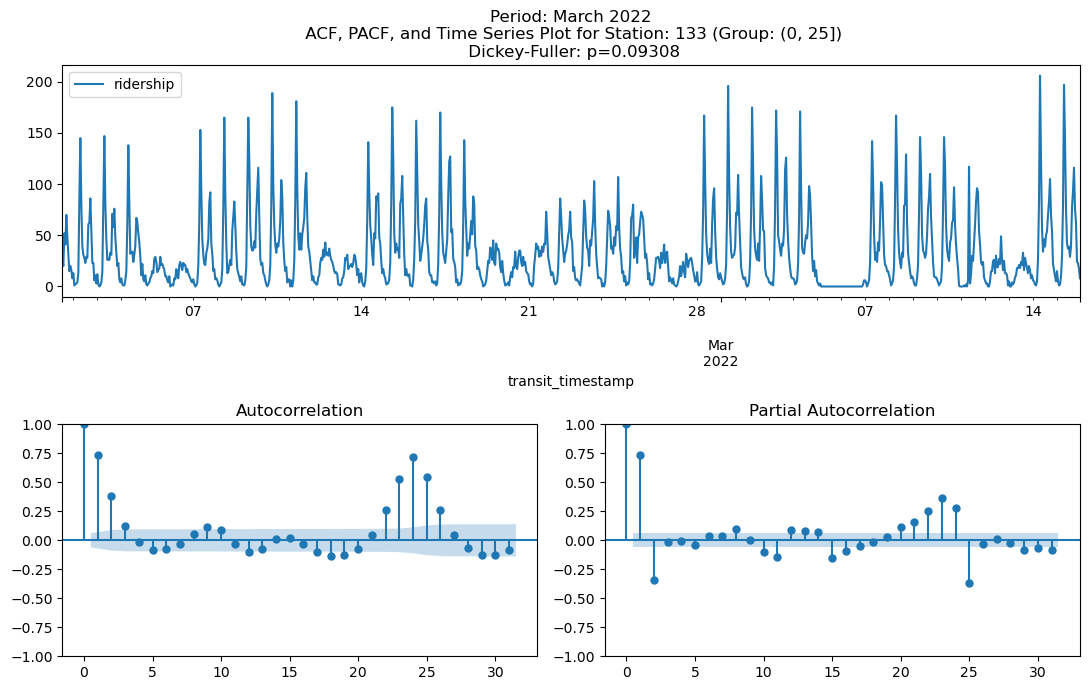

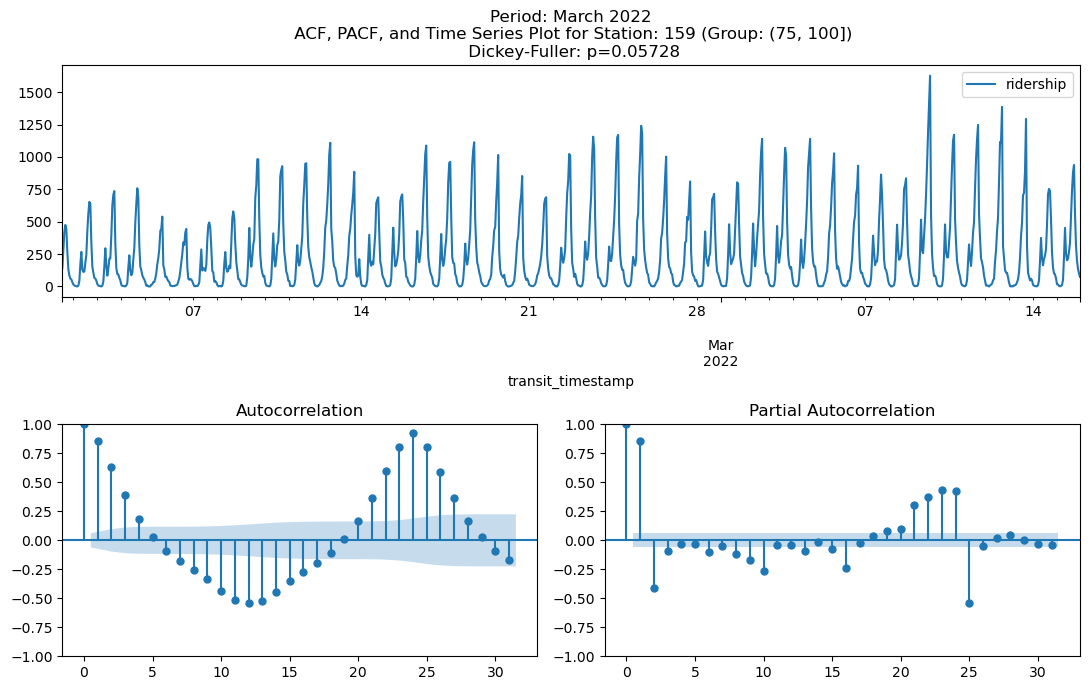

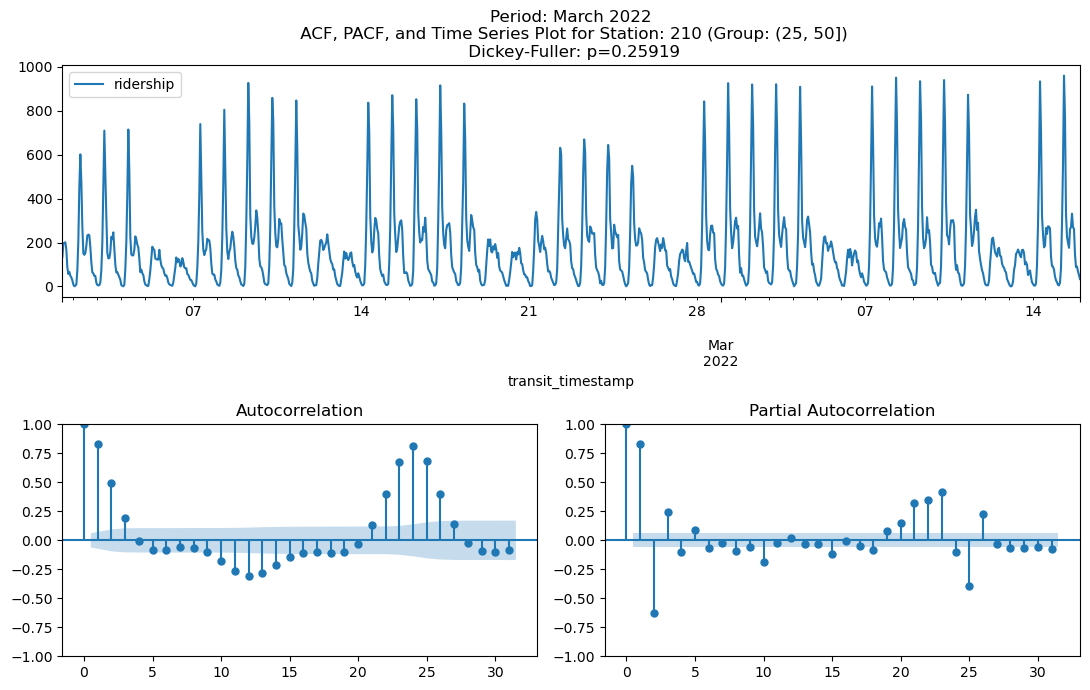

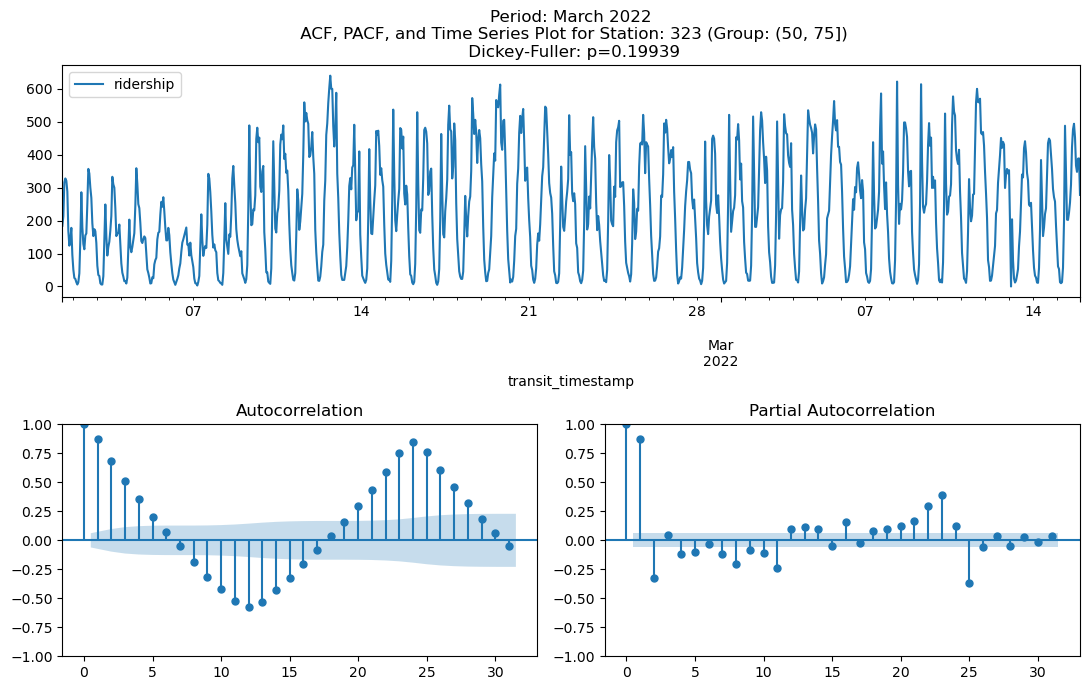

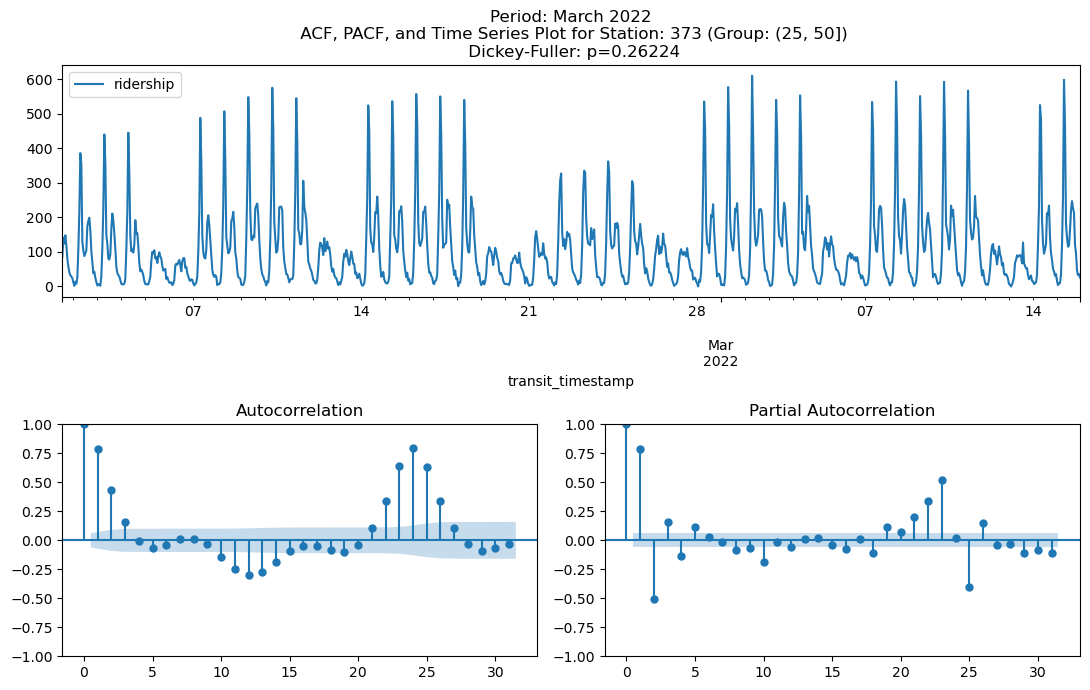

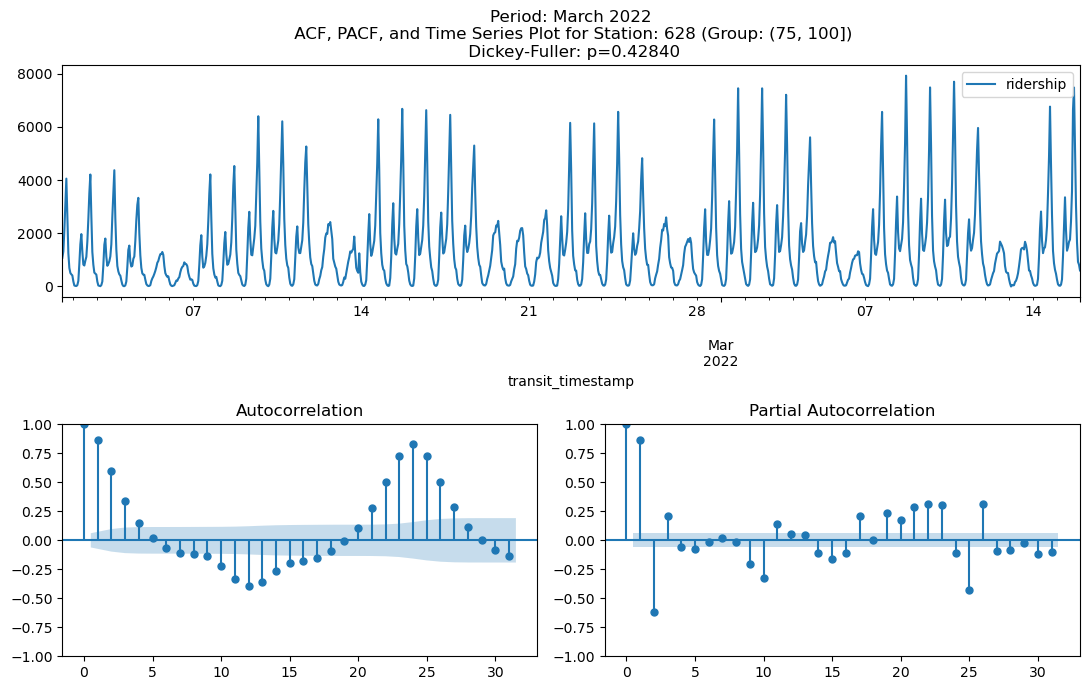

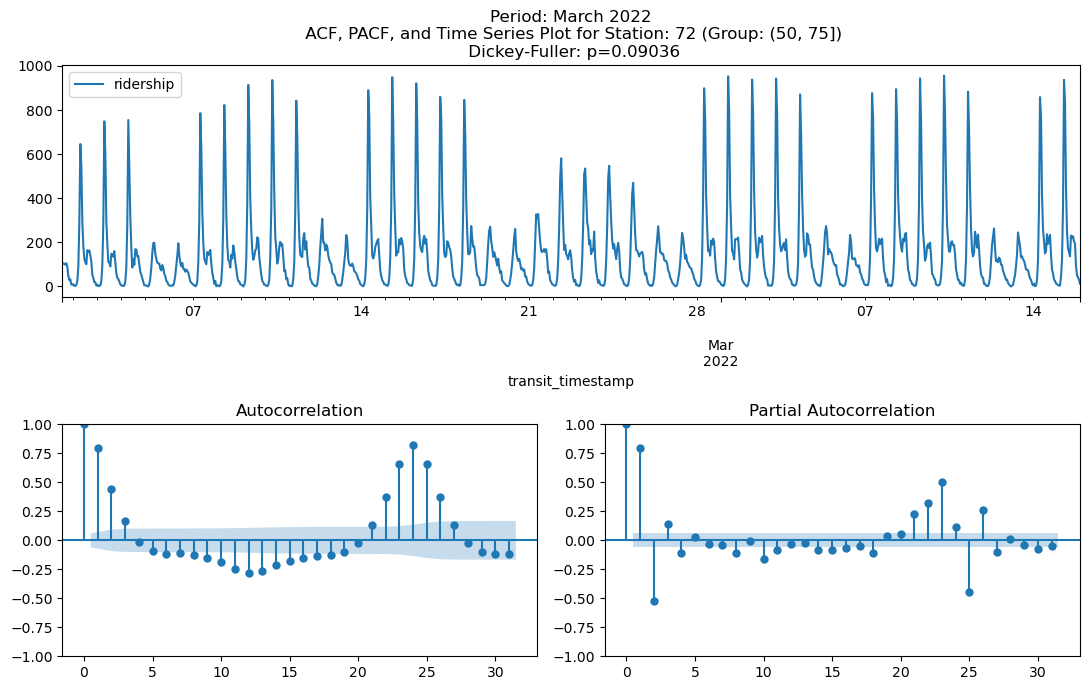

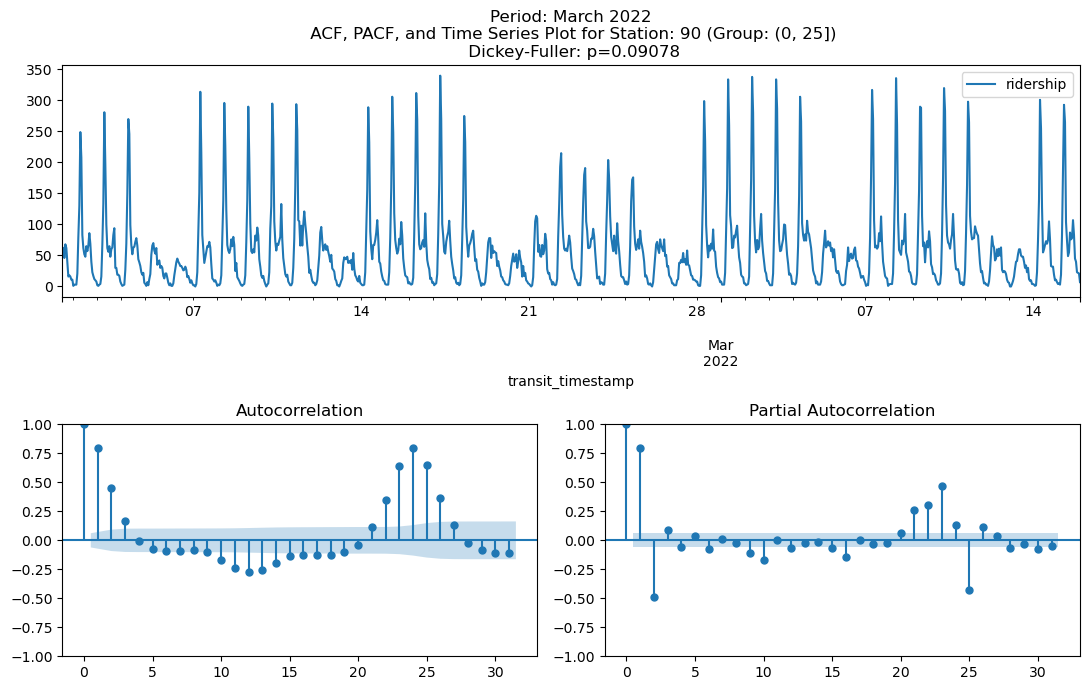

In [30]:
# For each time period and each station, produce ACF, PACF, and a time series plot including a Dickey-Fuller test p-value
# Mar 22
for station_id in ts_mar_22_main_plot["station_complex_id"].unique():
    # Subset data 
    mask = ts_mar_22_main_plot["station_complex_id"] == station_id
    plot_df = ts_mar_22_main_plot[mask] 
    group_val = plot_df["quant_group"].unique()[0]
    plot_df = plot_df.loc[:, ["transit_timestamp", "ridership"]]# drop not required columns
    
    # plots require the time variable to be the index 
    plot_df.set_index("transit_timestamp", inplace=True)

    # Use function from eda.py module 
    ts_analysis_plots(plot_df, figsize=(11, 7), title=f"Period: March 2022\n ACF, PACF, and Time Series Plot for Station: {station_id} (Group: {group_val})")
    
    

The first observation is, that the test does not reject the null-hypothesis given a predefined type 1 error tolerance of 5%. We will hence first take the first difference (i.e. minus previous hour) to see if we fare better with that. 

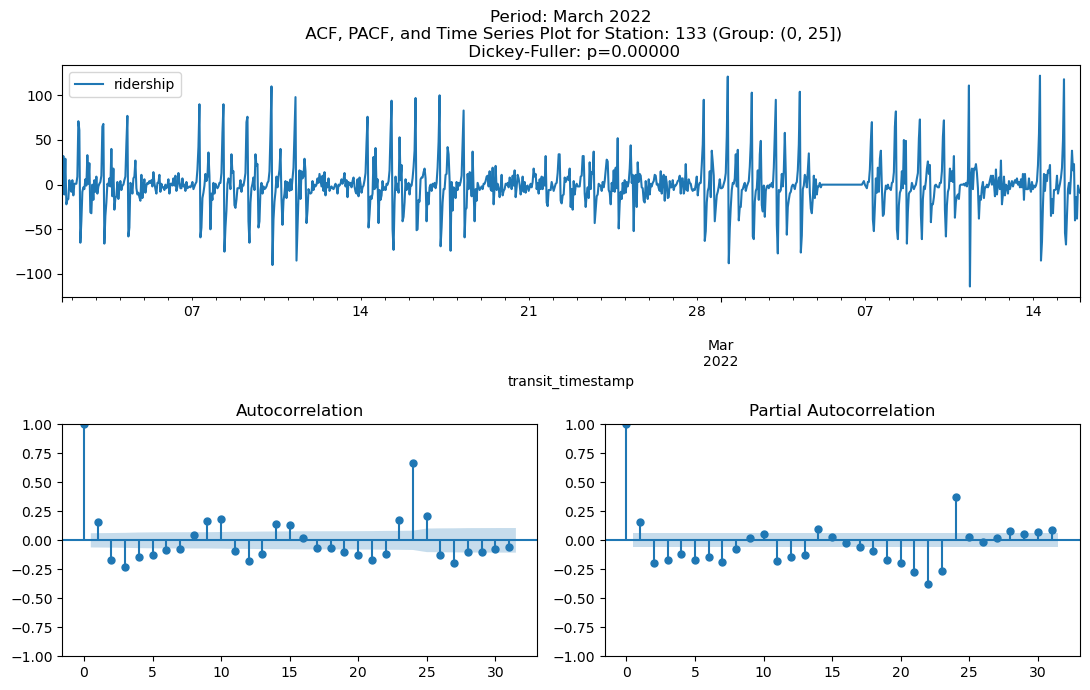

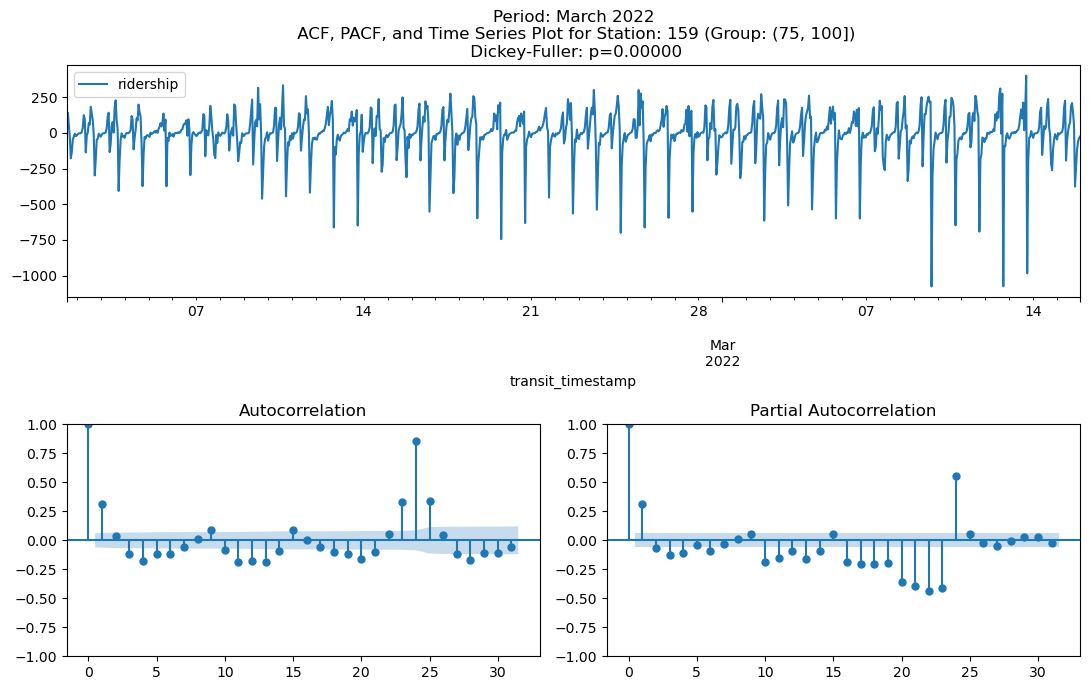

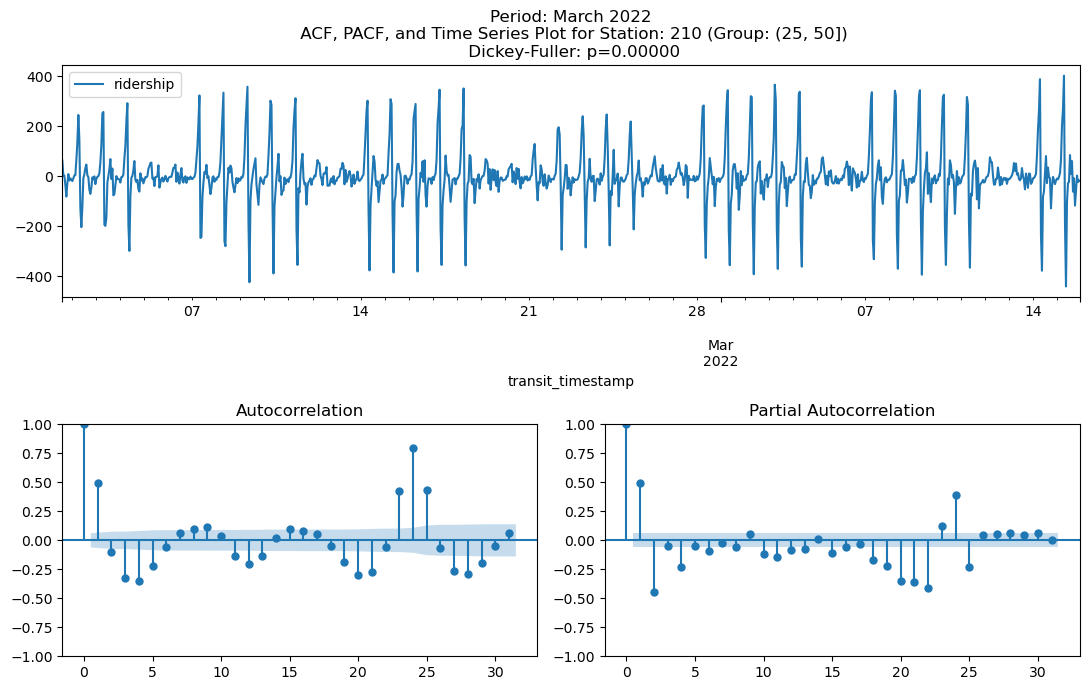

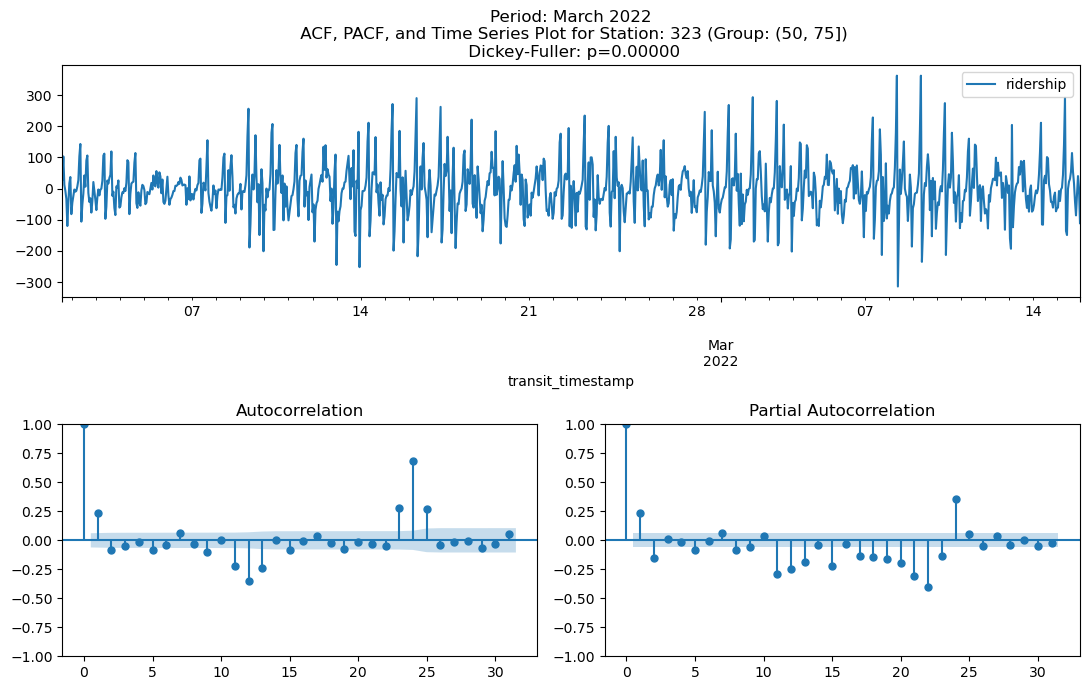

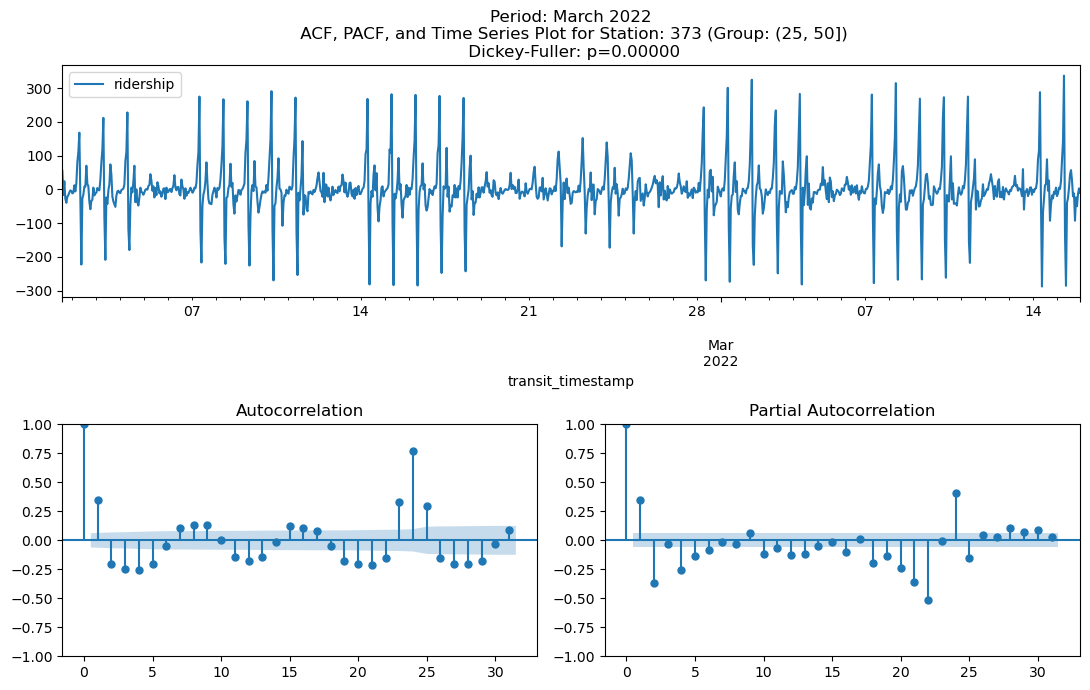

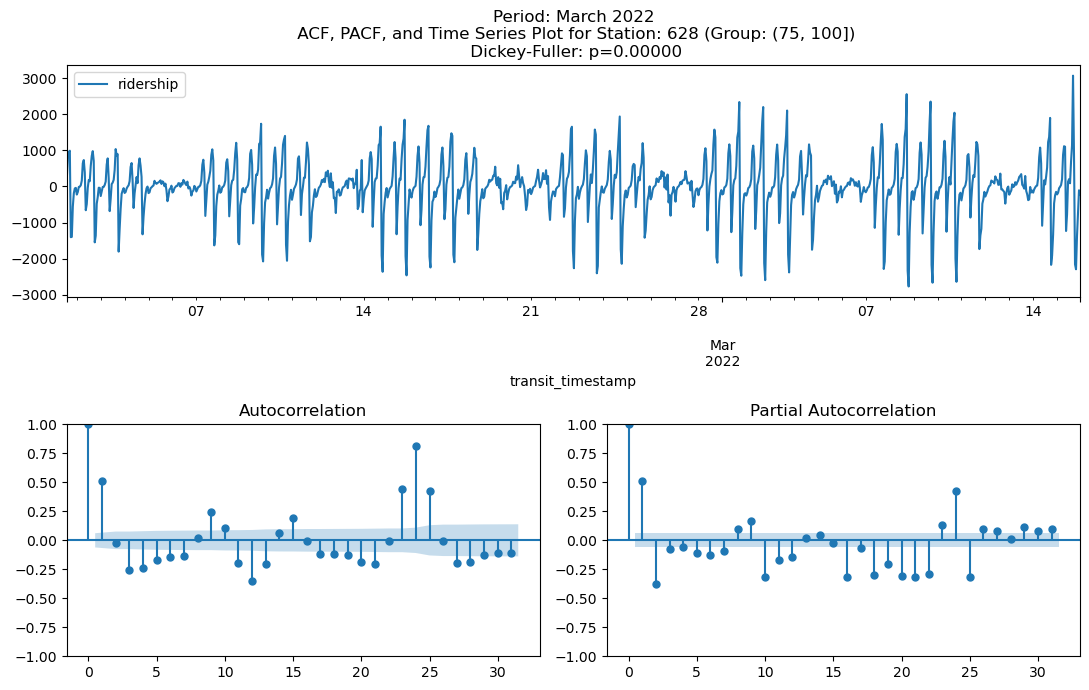

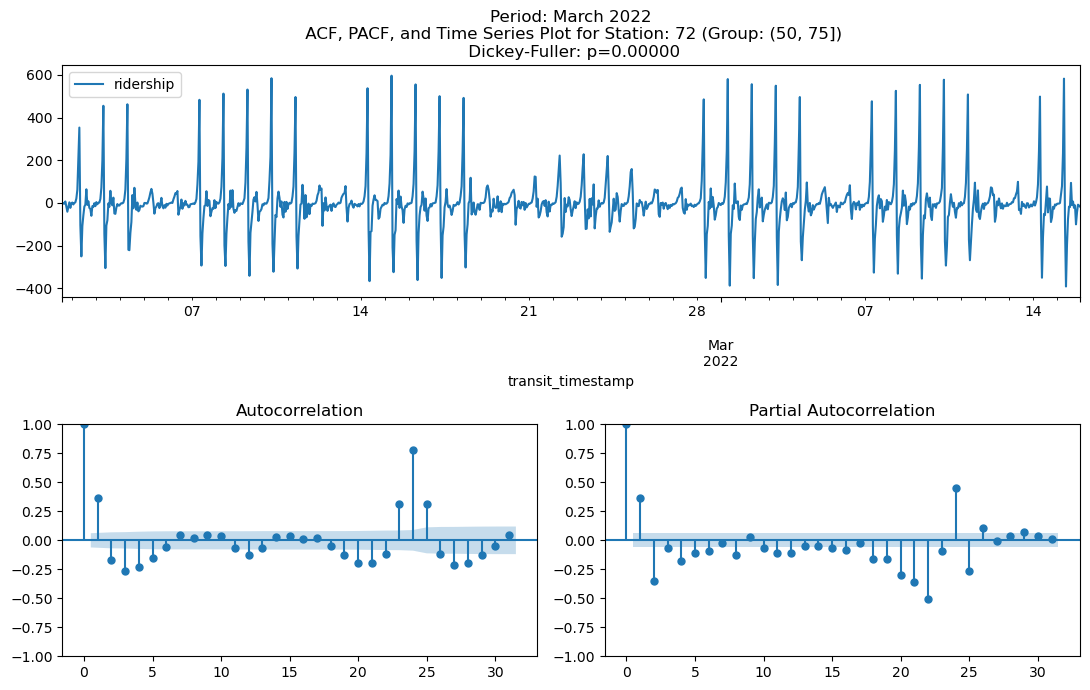

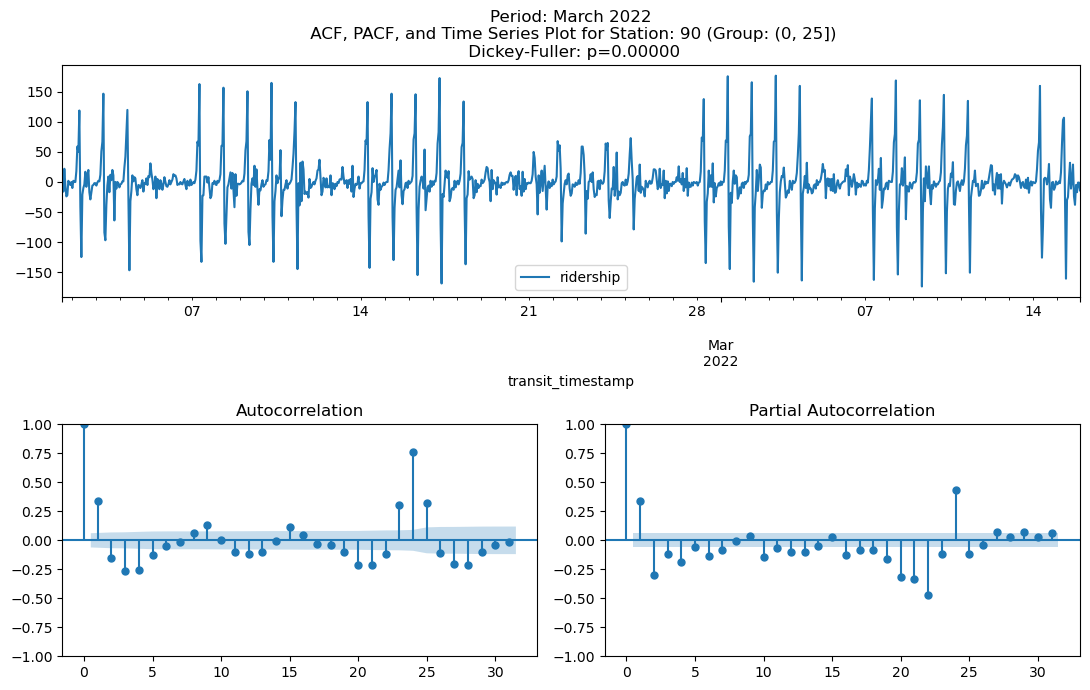

In [35]:
# For each time period and each station, produce ACF, PACF, and a time series plot including a Dickey-Fuller test p-value but now with one hour difference 
# Mar 22
for station_id in ts_mar_22_main_plot["station_complex_id"].unique():
    # Subset data 
    mask = ts_mar_22_main_plot["station_complex_id"] == station_id
    plot_df = ts_mar_22_main_plot[mask] 
    group_val = plot_df["quant_group"].unique()[0]
    plot_df = plot_df.loc[:, ["transit_timestamp", "ridership"]]# drop not required columns
    
    # plots require the time variable to be the index 
    plot_df.set_index("transit_timestamp", inplace=True)

    # Apply first difference (i.e. lag of 1)
    plot_df = (plot_df - plot_df.shift(1)).dropna()

    # Use function from eda.py module 
    ts_analysis_plots(plot_df, figsize=(11, 7), title=f"Period: March 2022\n ACF, PACF, and Time Series Plot for Station: {station_id} (Group: {group_val})")
    
    

Stationarity looks good now, as all test reject the null-hypothesis, that the process is non-stationary at 5% type 1 error tolerance. Now let us quickly for one station determine the othe ARIMA parameters in more detail, before just showing our values.
For station 133 we can see that the ACF signals that after a lag of 5 the significance reduces drastically, hence we pick for the moving average part of the ARIMA model the parameter 5. Additionally, the PACF plot shows significant lags up till lag 7, hence we pick for the autoregressive part the parameter 7. Thus the initial model parameter for station 133 are ARIMA(5,1,7) (again note that other parameters might be selected based on the ACF criterion). 

One important thing to note are the spikes that occur in all ACF plots around 24, i.e. 24 hours before the current observation. This shows a clear seasonal component for every 24h. We would also suspect the same pattern to occur for 7 x 24 = 168 hours, as the daily ridership plots suggested a weekly seasonality. This seasonal component influences our error metric used, as we describe in the next section., MA(5)

Other Stations:
133 : ARIMA(7,1,5), 159 : ARIMA(5,1,1), 210 : ARIMA(4,1,5), 323 : ARIMA(1,1,1), 373 : ARIMA(5,1,5), 628 : ARIMA(7,1,7), 72 : ARIMA(6,1,5), 90 : ARIMA(5,1,5) 

Let us quickly verify our seasonal finding by also plotting the power spectral density using a periodogram. 

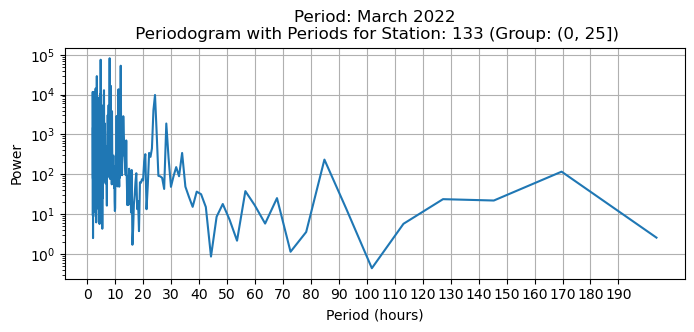

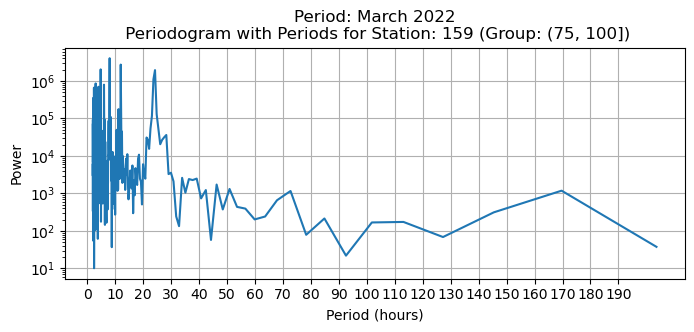

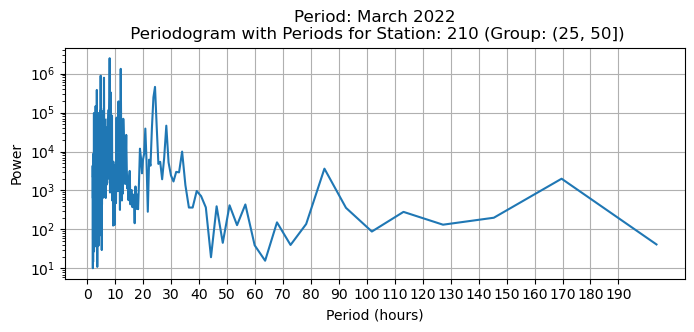

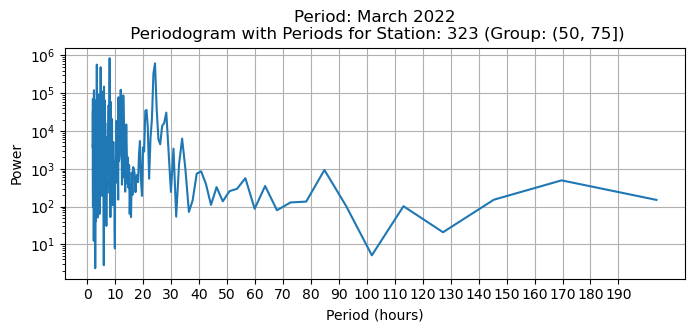

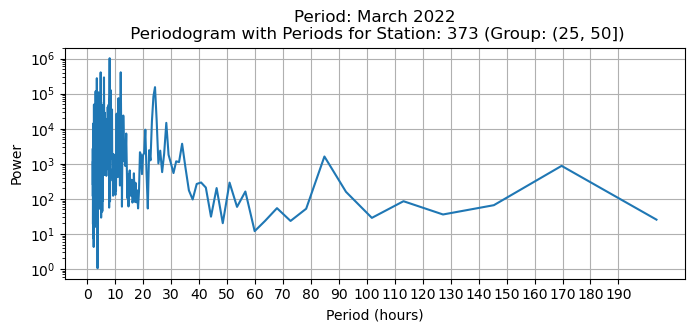

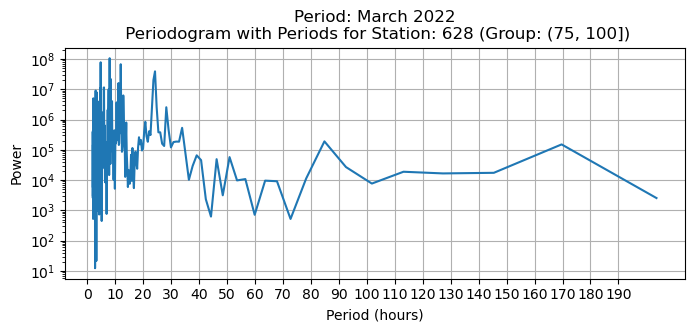

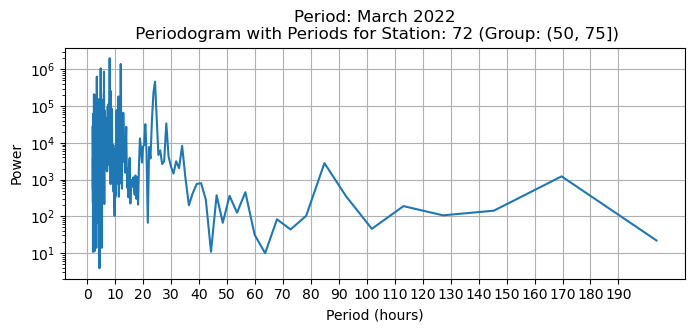

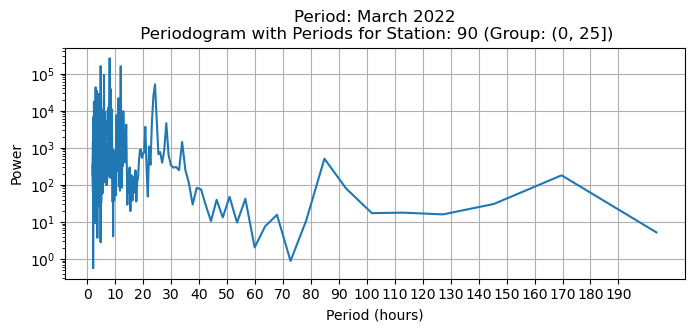

In [67]:
for station_id in ts_mar_22_main_plot["station_complex_id"].unique():
    # Subset data 
    mask = ts_mar_22_main_plot["station_complex_id"] == station_id
    plot_df = ts_mar_22_main_plot[mask] 
    group_val = plot_df["quant_group"].unique()[0]
    plot_df = plot_df.loc[:, ["transit_timestamp", "ridership"]]# drop not required columns
    
    # plots require the time variable to be the index 
    plot_df.set_index("transit_timestamp", inplace=True)

    # Apply first difference (i.e. lag of 1)
    plot_df = (plot_df - plot_df.shift(1)).dropna()

    # Setting sampling frequency to 1 as we convert frequency to periods (hours)
    fs = 1 
    
    # Computing the periodogram
    frequencies, power = periodogram(plot_df["ridership"].values, fs=fs)

    # Convert frequencies to periods (in hours), avoiding division by zero
    periods = 1 / frequencies[1:]  # Skip the first element to avoid dividing by zero
    
    # Corresponding power values, excluding the first element
    power_periods = power[1:]
    
    # Plotting the periodogram with periods on the x-axis (only show 10 days)
    plt.figure(figsize=(8, 3))
    plt.semilogy(periods[periods<=240], power_periods[periods<=240])
    plt.title(f"Period: March 2022\n Periodogram with Periods for Station: {station_id} (Group: {group_val})")
    plt.xlabel("Period (hours)")
    plt.ylabel("Power")
    plt.xticks(np.arange(0, 200, 10))
    plt.grid(True)
    plt.show()


Not too suprising we see many peaks for the lags up to the 10 hour mark and clearly a peak at the 24 hour mark which confirms our finding. Interestingly enough we see a small spike arount 85 hour mark with many stations for the March period, which we cannot readily explain. Let us now move to the modeling part.

## 3.2 Model Training & Forecasting
Before we proceed let us summarize our approach for the following two sections and provide our rationale. First of all, we opted for an ARIMA model as a "simple" base line model and compare it to a non-linear machine learning model (i.e. the ensemble model). As ARIMA models are easy to understand, explainable, and widely used, we propose that any other model selected, should at least outperform this base line model (assuming prediction performance is the key metric). We decided to use the LightGBM implementation both because it is faster than XGBoost, but also because boosted tree regressors tend to produce solid results in time series regression tasks (see e.g. the M5 competition https://www.sciencedirect.com/science/article/pii/S0169207021001874). In the last chapter we also highlight other models we did not try, but would have liked to do so. 

For the error metric we opted for the mean absolute scaled error (MASE) with the modification for seasonal time series. The rationale behind this is twofold. One is the inapplicability of other available metrics given our goal (staffing of stations) and the underlying data. We see huge differences in total ridership between stations, not only daily but also hourly and any metric prone to absolute scales such as MAE or MSE wouldn't allow us to compare error metrics between series (stations). Additionally, as the ranges in absolute terms are quite large for some stations, we would probably over- or understaff stations with high absolute ridership numbers. Percentage based error metrics are also off the table, as there are hours with 0 ridership and thus they would need to be crudely adjusted. Scaled error metrics such as MASE are not prone to these shortcomings, but in the case of MASE have one drawback: One has to define a seasonal window for the naive forecaster used. In our case, we can be certain that 24 is a seasonal cycle (see 3.1) but from 2.2 we also know that there is a seasonal weekly cycle. We will mention this in the last chapter as well, but in a real-world scenario we would have created a custom error metric, which combines both seasonal components we know of (and potentially even more) into one metric. 

Here $e_j$ is the absolute forecast error, which is then compared with the error a naive forecaster would incurr. $m$ describes the seasonal shift, so in our case $m=24$

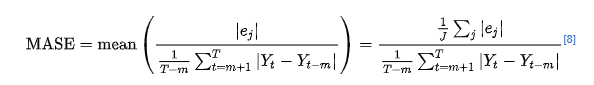

### 3.2.1 ARIMA
We will extensively utilize the sktime library, as well as the LightGBM library to train the models. We opted for the LightGBM implementation, as it is usually much faster than XGBoost, again suiting our perspective within this task that faster computation is more important than performance. Again, note that the ARIMA implementation in sktime is a wrapper around pmdarima which is an AutoARIMA implementation for Python. Note that we techniqally fit a SARIMA model, since we set a seasonal parameter as well.

In [93]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.arima import AutoARIMA

mask = (ts_mar_22_main_plot["station_complex_id"] == "133") & (ts_mar_22_main_plot["test_ind"] == 0)
subset = ts_mar_22_main_plot.loc[mask, "ridership"].reset_index(drop=True)

mask = (ts_mar_22_main_plot["station_complex_id"] == "133") & (ts_mar_22_main_plot["test_ind"] == 1)
test_set = ts_mar_22_main_plot.loc[mask, "ridership"].reset_index(drop=True)
# subset.set_index("transit_timestamp", inplace=True)
# subset.index = subset.index.astype(int)

forecaster = AutoARIMA(start_p=2, max_p=12, d=1, start_q=2, max_q=12,
                       stationary = True, sp = 24, suppress_warnings=True)
forecaster.fit(subset)
print(forecaster.summary())

fh = np.arange(len(test_set)) + 1
forecast = forecaster.predict(fh=fh)

print(mean_absolute_scaled_error(y_true=test_set, y_pred=forecast, y_train=subset, sp=24))
print(mean_absolute_error(y_true=test_set, y_pred=forecast))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  659
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood               -2715.912
Date:                            Fri, 12 Apr 2024   AIC                           5451.823
Time:                                    15:56:04   BIC                           5496.730
Sample:                                         0   HQIC                          5469.231
                                            - 659                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1949      0.950      2.311      0.021       0.334       4.056
ar.L1         -0.4607      0.047   

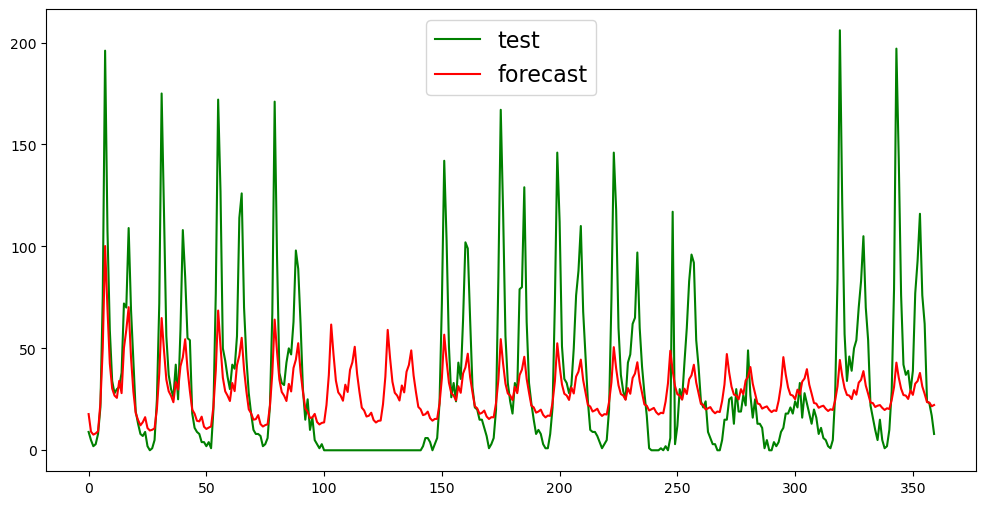

In [94]:
plt.figure(figsize=(12, 6))
# subset.plot(label="train", color="b")
test_set.plot(label="test", color="g")
forecast.index = test_set.index
forecast.plot(label="forecast", color="r")
# if forecast_int is not None:
#     plt.fill_between(
#         series_test.index,
#         forecast_int["lower"],
#         forecast_int["upper"],
#         alpha=0.2,
#         color="dimgray",
#     )
plt.legend(prop={"size": 16})
plt.show()

In [141]:
mask = (ts_mar_22_main_plot["test_ind"] == 0)
subset = ts_mar_22_main_plot.loc[mask, ["ridership", "station_complex_id", "transit_timestamp"]].set_index(["station_complex_id", "transit_timestamp"])

mask =(ts_mar_22_main_plot["test_ind"] == 1)
test_set = ts_mar_22_main_plot.loc[mask, ["ridership", "station_complex_id", "transit_timestamp"]].set_index(["station_complex_id", "transit_timestamp"]) #.reset_index(drop=True)

forecaster = AutoARIMA(start_p=2, max_p=12, d=1, start_q=2, max_q=12, suppress_warnings=True)
forecaster.fit(subset)
for i in range(len(forecaster.forecasters_)):
    print(forecaster.forecasters_.iloc[i, 0].summary())

len_test_set = len(test_set.index.get_level_values(level=1).unique()) # Get unique time index length (is the same for all stations)
fh = np.arange(len_test_set) + 1
forecast = forecaster.predict(fh=fh)

print(mean_absolute_scaled_error(y_true=test_set, y_pred=forecast, y_train=subset, sp=24))
print(mean_absolute_error(y_true=test_set, y_pred=forecast))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  659
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -2997.783
Date:                Fri, 12 Apr 2024   AIC                           6001.566
Time:                        16:27:55   BIC                           6015.033
Sample:                    02-01-2022   HQIC                          6006.787
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1220      0.021      5.749      0.000       0.080       0.164
ma.L2         -0.1486      0.031     -4.752      0.000      -0.210      -0.087
sigma2       529.6564     16.334     32.426      0.0

In [148]:
print(mean_absolute_error(y_true=test_set, y_pred=forecast, multioutput="raw_values"))

[265.4891525]


In [146]:
test_set.shape, forecast.shape, subset.shape

((2880, 1), (2880, 1), (5272, 1))

In [152]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb

def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster


def grid_search_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid, 
        scoring=mean_absolute_scaled_error
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    print("Error:", mean_absolute_scaled_error(y_true=test, y_pred=y_pred, y_train=train, sp=24))

    return y_pred, gscv


In [155]:
mask = (ts_mar_22_main_plot["station_complex_id"] == "133") & (ts_mar_22_main_plot["test_ind"] == 0)
train_set = ts_mar_22_main_plot.loc[mask, ["ridership", "station_complex_id", "transit_timestamp"]].set_index(["station_complex_id", "transit_timestamp"])

mask = (ts_mar_22_main_plot["station_complex_id"] == "133") & (ts_mar_22_main_plot["test_ind"] == 1)
test_set = ts_mar_22_main_plot.loc[mask, ["ridership", "station_complex_id", "transit_timestamp"]].set_index(["station_complex_id", "transit_timestamp"]) #.reset_index(drop=True)

a = np.arange(2, 16, 2)
param_grid = {
    "window_length": [*a, 24, 36, 48] # parameter set to be grid searched (lags)
}
forecaster = create_forecaster()
preds,tree_model = grid_search_forecaster(train_set, test_set, forecaster, param_grid)

C:\Users\agottsch\Anaconda3\envs\jet_env\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\Users\agottsch\Anaconda3\envs\jet_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 36
[LightGBM] [Info] Start training from score 32.089888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

<Figure size 1200x600 with 0 Axes>

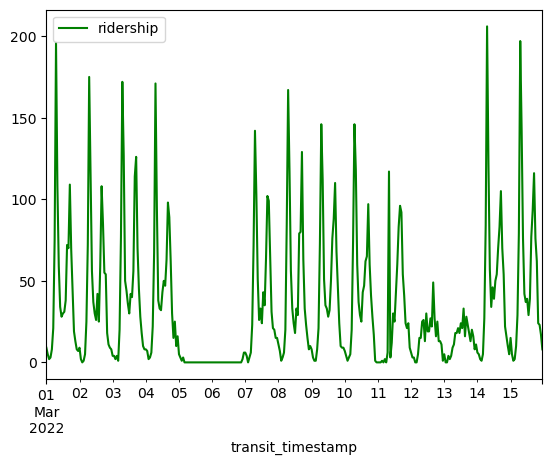

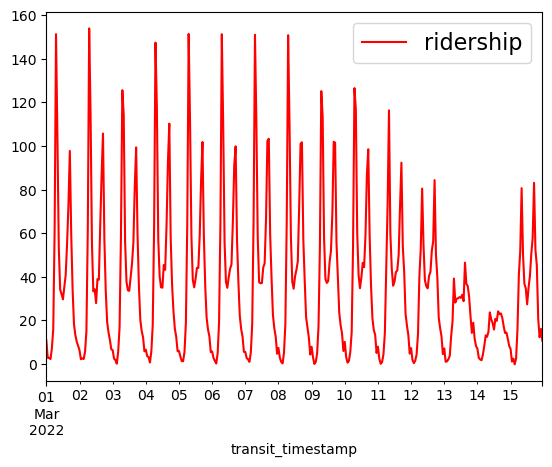

In [162]:
a = preds.droplevel(level=0)
b = test_set.droplevel(level=0)

plt.figure(figsize=(12, 6))
b.plot(label="test", color="g")
a.index = b.index
a.plot(label="forecast", color="r")
# if forecast_int is not None:
#     plt.fill_between(
#         series_test.index,
#         forecast_int["lower"],
#         forecast_int["upper"],
#         alpha=0.2,
#         color="dimgray",
#     )
plt.legend(prop={"size": 16})
plt.show()

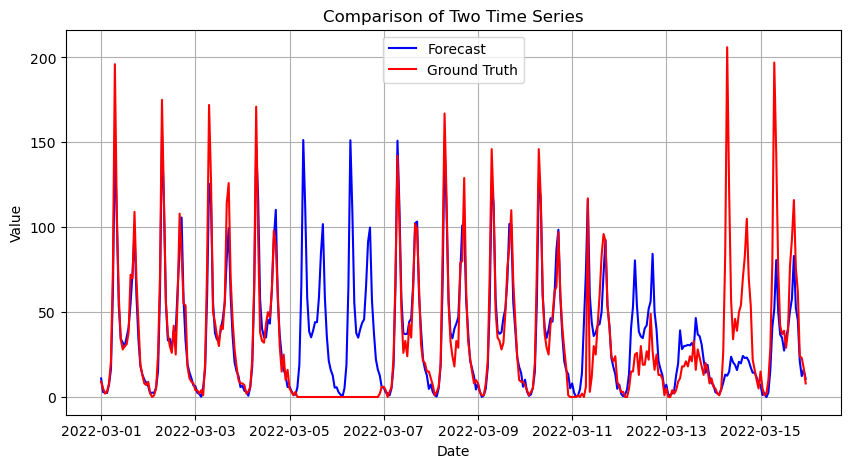

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(a.index, a.values, label='Forecast', color='blue')  # Plotting the first series in blue
plt.plot(b.index, b.values, label='Ground Truth', color='red')   # Plotting the second series in red
plt.title('Comparison of Two Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mask = (ts_mar_22_main_plot["station_complex_id"] == "133") & (ts_mar_22_main_plot["test_ind"] == 0)
train_set = ts_mar_22_main_plot.loc[mask, ["ridership", "station_complex_id", "transit_timestamp"]].set_index(["station_complex_id", "transit_timestamp"])

mask = (ts_mar_22_main_plot["station_complex_id"] == "133") & (ts_mar_22_main_plot["test_ind"] == 1)
test_set = ts_mar_22_main_plot.loc[mask, ["ridership", "station_complex_id", "transit_timestamp"]].set_index(["station_complex_id", "transit_timestamp"]) #.reset_index(drop=True)

a = np.arange(2, 16, 2)
param_grid = {
    "window_length": [*a, 24, 36, 48] # parameter set to be grid searched (lags)
}
forecaster = create_forecaster()
preds,tree_model = grid_search_forecaster(train_set, test_set, forecaster, param_grid)

In [171]:
missing_hours.reset_index().groupby(['hour']).size()

hour
0     4126
1     5855
2     7020
3     5241
4     3055
5     2362
6     2277
7     2260
8     2270
9     2263
10    2277
11    2288
12    2260
13    2226
14    2220
15    2208
16    2201
17    2207
18    2257
19    2329
20    2372
21    2412
22    2629
23    2990
dtype: int64